In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import time

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device is using: {device}")

Current device is using: cuda


In [2]:
# ---------------------
# Define Helper Classes and Functions
# ---------------------
class MultiStepTimeSeriesDataset(Dataset):
    """
    Dataset for multi-step forecasting. Inputs are sequences of length `seq_len`,
    and targets are `forecast_horizon` steps ahead.
    """
    def __init__(self, X, y, seq_len, forecast_horizon):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        return len(self.X) - self.seq_len - self.forecast_horizon + 1

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx:idx + self.seq_len], dtype=torch.float32),
            torch.tensor(self.y[idx + self.seq_len:idx + self.seq_len + self.forecast_horizon], dtype=torch.float32),
        )

class LSTMForecastModel(nn.Module):
    """
    LSTM model for multi-step forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=3, dropout=0.3):
        super(LSTMForecastModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, forecast_horizon)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # Output based on the last hidden state

class LSTMMonteCarlo(nn.Module):
    """
    LSTM model with Monte Carlo dropout for uncertainty estimation.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=2, dropout=0.2, recurrent_dropout=0.2):
        """
        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden units in each LSTM layer.
            forecast_horizon: Number of steps to forecast.
            num_layers: Number of stacked LSTM layers.
            dropout: Dropout rate applied to the fully connected layer.
            recurrent_dropout: Dropout rate applied between LSTM layers.
        """
        super(LSTMMonteCarlo, self).__init__()

        # LSTM layer(s)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=recurrent_dropout  # Recurrent dropout
        )
        
        # Layer normalization (optional but improves convergence)
        self.layer_norm = nn.LayerNorm(hidden_size)

        # Dropout for fully connected layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer for final output
        self.fc = nn.Linear(hidden_size, forecast_horizon)

    def forward(self, x):
        """
        Forward pass through LSTM with Monte Carlo dropout.
        """
        # LSTM output: (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)

        # Take the last hidden state
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_size)

        # Normalize and apply dropout
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)

        # Final output through fully connected layer
        return self.fc(lstm_out)

def lstm_monte_carlo_dropout_inference(model, inputs, n_simulations=100, verbose=False):
    """
    Perform Monte Carlo dropout during inference to estimate uncertainty.

    Args:
        model: Trained LSTMMonteCarlo model.
        inputs: Input tensor for prediction (shape: [batch_size, seq_len, input_size]).
        n_simulations: Number of Monte Carlo simulations.
        verbose: Whether to print intermediate predictions for debugging.

    Returns:
        mean_predictions: Mean of predictions across simulations.
        uncertainty: Standard deviation of predictions across simulations.
    """
    model.train()  # Keep dropout active during inference
    predictions = []

    with torch.no_grad():
        for i in range(n_simulations):
            pred = model(inputs)  # Shape: [batch_size, forecast_horizon]
            predictions.append(pred.cpu().numpy())
            if verbose:
                print(f"Simulation {i + 1}: {pred.cpu().numpy()}")

    # Convert predictions to numpy array
    predictions = np.array(predictions)  # Shape: [n_simulations, batch_size, forecast_horizon]

    # Compute mean and standard deviation across simulations
    mean_predictions = np.mean(predictions, axis=0)  # Shape: [batch_size, forecast_horizon]
    uncertainty = np.std(predictions, axis=0)        # Shape: [batch_size, forecast_horizon]

    return mean_predictions, uncertainty


class LSTMCNN(nn.Module):
    """
    LSTM-CNN hybrid model for multi-step time series forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=2, cnn_filters=128, kernel_size=3, dropout=0.2):
        """
        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden units in the LSTM layer.
            forecast_horizon: Number of steps ahead to forecast.
            num_layers: Number of stacked LSTM layers.
            cnn_filters: Number of filters in the CNN layer.
            kernel_size: Size of the convolution kernel.
            dropout: Dropout probability for regularization.
        """
        super(LSTMCNN, self).__init__()
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # CNN Layer
        self.conv = nn.Conv1d(
            in_channels=hidden_size, 
            out_channels=cnn_filters, 
            kernel_size=kernel_size, 
            padding=kernel_size // 2  # To maintain the same spatial size
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(cnn_filters, forecast_horizon)
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass for LSTM-CNN model.
        """
        # LSTM output: (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        # Permute for CNN: (batch_size, hidden_size, seq_len)
        lstm_out = lstm_out.permute(0, 2, 1)
        # Apply CNN: (batch_size, cnn_filters, seq_len)
        cnn_out = self.conv(lstm_out)
        # Global Average Pooling: (batch_size, cnn_filters)
        cnn_out = cnn_out.mean(dim=-1)
        # Dropout for regularization
        cnn_out = self.dropout(cnn_out)
        # Fully Connected Layer
        output = self.fc(cnn_out)
        
        return output

class RNNForecastModel(nn.Module):
    """
    Improved Vanilla RNN model for multi-step time series forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=2, nonlinearity='tanh', dropout=0.2):
        """
        Args:
            input_size: Number of input features.
            hidden_size: Number of hidden units in each RNN layer.
            forecast_horizon: Number of steps to forecast.
            num_layers: Number of stacked RNN layers.
            nonlinearity: Nonlinearity for RNN ('tanh' or 'relu').
            dropout: Dropout probability for regularization.
        """
        super(RNNForecastModel, self).__init__()

        # RNN layer(s)
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity=nonlinearity,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0  # Dropout applies only when num_layers > 1
        )

        # Layer Normalization
        self.layer_norm = nn.LayerNorm(hidden_size)

        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, forecast_horizon)

        # Dropout for FC layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass through RNN model.
        """
        # RNN output: (batch_size, seq_len, hidden_size)
        rnn_out, _ = self.rnn(x)

        # Take the last hidden state
        rnn_out = rnn_out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Apply layer normalization and dropout
        rnn_out = self.layer_norm(rnn_out)
        rnn_out = self.dropout(rnn_out)

        # Pass through fully connected layer
        output = self.fc(rnn_out)  # Shape: (batch_size, forecast_horizon)

        return output


        
class LSTMRNNForecastModel(nn.Module):
    """
    LSTM-RNN hybrid model for multi-step forecasting.
    """
    def __init__(self, input_size, hidden_size, forecast_horizon, num_layers=3, dropout=0.3):
        super(LSTMRNNForecastModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu', dropout=dropout)
        self.fc = nn.Linear(hidden_size, forecast_horizon)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        rnn_out, _ = self.rnn(lstm_out)
        return self.fc(rnn_out[:, -1, :])  # Output based on the last hidden state




def scale_data(df, features, target, method="normalize"):
    """
    Normalize or standardize data using MinMaxScaler or StandardScaler.
    """
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    X = feature_scaler.fit_transform(df[features])
    y = target_scaler.fit_transform(df[target].values.reshape(-1, 1))

    return X, y.ravel(), feature_scaler, target_scaler

def denormalize(predictions, scaler):
    """
    Denormalize predictions using the target scaler.
    """
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()


In [30]:
# ---------------------
# Step 1: Data Preparation
# ---------------------
# Load the dataset
data = pd.read_csv('data/final_df.csv')
data.set_index("Date", inplace=True)


# Define features and target
features = [
    'Open', 'High', 'Low', 'GDP (constant 2015 MYR)', 'GDP Growth YOY (%)', 
    'OPR (%)', 'MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'RSI_50', 'BB_upper', 
    'BB_lower', 'GDP (constant 2015 MYR)_Lag_30D', 'GDP (constant 2015 MYR)_Lag_90D', 
    'GDP (constant 2015 MYR)_Lag_180D', 'GDP (constant 2015 MYR)_Lag_365D', 
    'OPR (%)_Lag_30D', 'OPR (%)_Lag_90D', 'Lagged_Close_30D', 'Lagged_Close_90D', 
    'Lagged_Close_180D', 'Lagged_Close_365D'
]
target = "Close"

# Normalize data
X, y, feature_scaler, target_scaler = scale_data(data, features, target)

# Split data into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# ---------------------
# Step 2: Model Training
# ---------------------
seq_len = 365  # Sequence length
forecast_horizon = 365  # Forecast for August 2024 (31 days)

# Create data loaders
train_dataset = MultiStepTimeSeriesDataset(X_train, y_train, seq_len, forecast_horizon)
val_dataset = MultiStepTimeSeriesDataset(X_val, y_val, seq_len, forecast_horizon)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
model = RNNForecastModel(
    input_size=X_train.shape[1], 
    hidden_size=128, 
    forecast_horizon=forecast_horizon, 
    num_layers=3, 
    nonlinearity='tanh',
    dropout=0.2
).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Start timer
start_time = time.time()

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Stop timer
end_time = time.time()
training_duration = end_time - start_time

# Print training duration
print(f"Training completed in {training_duration:.2f} seconds.")

# Save model and scalers
torch.save(model, "forecast/rnn/rnn3_forecast_model.pth")
joblib.dump(feature_scaler, "forecast/rnn/feature3_scaler.pkl")
joblib.dump(target_scaler, "forecast/rnn/target3_scaler.pkl")


Epoch 1/150, Train Loss: 35.8161, Val Loss: 0.1050
Epoch 2/150, Train Loss: 14.6348, Val Loss: 0.1196
Epoch 3/150, Train Loss: 12.4140, Val Loss: 0.2922
Epoch 4/150, Train Loss: 10.2294, Val Loss: 0.2835
Epoch 5/150, Train Loss: 8.9579, Val Loss: 0.2797
Epoch 6/150, Train Loss: 7.9384, Val Loss: 0.3022
Epoch 7/150, Train Loss: 6.9844, Val Loss: 0.3013
Epoch 8/150, Train Loss: 6.1176, Val Loss: 0.1856
Epoch 9/150, Train Loss: 5.2740, Val Loss: 0.2915
Epoch 10/150, Train Loss: 4.5239, Val Loss: 0.2955
Epoch 11/150, Train Loss: 3.9177, Val Loss: 0.3267
Epoch 12/150, Train Loss: 3.4118, Val Loss: 0.4081
Epoch 13/150, Train Loss: 3.0758, Val Loss: 0.2216
Epoch 14/150, Train Loss: 2.7514, Val Loss: 0.2726
Epoch 15/150, Train Loss: 2.5233, Val Loss: 0.3385
Epoch 16/150, Train Loss: 2.3371, Val Loss: 0.2614
Epoch 17/150, Train Loss: 2.2027, Val Loss: 0.2621
Epoch 18/150, Train Loss: 2.0935, Val Loss: 0.2957
Epoch 19/150, Train Loss: 2.0223, Val Loss: 0.3121
Epoch 20/150, Train Loss: 1.9176, Va

['forecast/rnn/target3_scaler.pkl']

C:\Users\kh\AppData\Local\Temp\ipykernel_8732\2091489385.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('forecast/rnn/rnn3_forecast_model.pth').to(de

Forecast Dates: DatetimeIndex(['2023-06-30', '2023-07-01', '2023-07-02', '2023-07-03',
               '2023-07-04', '2023-07-05', '2023-07-06', '2023-07-07',
               '2023-07-08', '2023-07-09',
               ...
               '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22',
               '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28'],
              dtype='datetime64[ns]', length=365, freq='D')
Actual Dates: DatetimeIndex(['2023-06-30', '2023-07-01', '2023-07-02', '2023-07-03',
               '2023-07-04', '2023-07-05', '2023-07-06', '2023-07-07',
               '2023-07-08', '2023-07-09',
               ...
               '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22',
               '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28'],
              dtype='datetime64[ns]', length=365, freq='D')
Forecast Shape: (365,), Forecast Values: [ 9.76381    9.749637   9.743

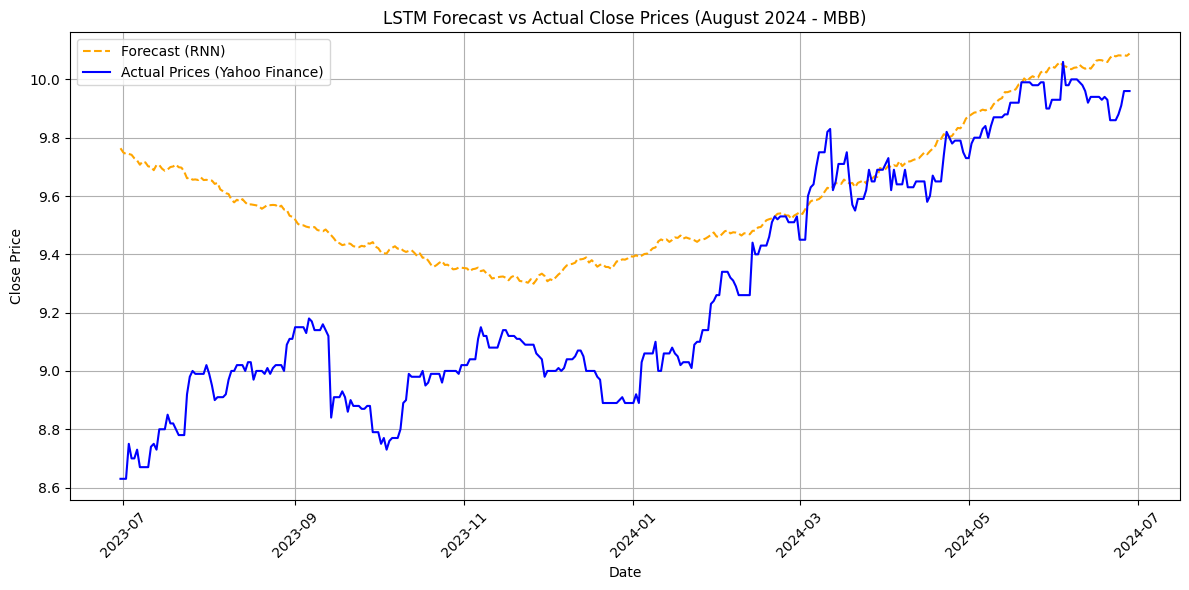

In [38]:
# ---------------------
# Step 3: Forecasting
# ---------------------
# Load the model and scalers
# model.load_state_dict(torch.load("forecast/lstm_forecast_model.pth"))
model = torch.load('forecast/rnn/rnn3_forecast_model.pth').to(device)
# model.eval()
feature_scaler = joblib.load("forecast/rnn/feature3_scaler.pkl")
target_scaler = joblib.load("forecast/rnn/target3_scaler.pkl")

# Prepare the input for forecasting
last_sequence = X_test[-seq_len:]  # Last sequence from the test set
last_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

# Forecast
model.eval()
with torch.no_grad():
    forecast = model(last_sequence).cpu().numpy().flatten()

# Denormalize the forecast
forecast = denormalize(forecast, target_scaler)

# Forecast dates
forecast_dates = pd.date_range(start="2023-06-30", periods=forecast_horizon)

# Fetch actual prices from Yahoo Finance
ticker = "1155.KL"
actual_data = yf.download(ticker, start="2023-06-30", end="2024-07-01")

# Reindex actual data to match forecast dates and forward-fill missing values
actual_data = actual_data.reindex(forecast_dates, method='ffill')  # Forward-fill missing dates
actual_prices = actual_data['Close'].values
actual_dates = actual_data.index

# Debugging outputs
print(f"Forecast Dates: {forecast_dates}")
print(f"Actual Dates: {actual_dates}")
print(f"Forecast Shape: {forecast.shape}, Forecast Values: {forecast}")
print(f"Actual Prices Shape: {actual_prices.shape}, Actual Prices: {actual_prices}")

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast, label="Forecast (RNN)", linestyle="--", color="orange")
plt.plot(actual_dates, actual_prices, label="Actual Prices (Yahoo Finance)", linestyle="-", color="blue")
plt.title("LSTM Forecast vs Actual Close Prices (August 2024 - MBB)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\kh\AppData\Local\Temp\ipykernel_8732\1777850448.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('forecast/rnn/rnn3_forecast_model.pth').to(de

Forecast Dates: DatetimeIndex(['2023-06-30', '2023-07-01', '2023-07-02', '2023-07-03',
               '2023-07-04', '2023-07-05', '2023-07-06', '2023-07-07',
               '2023-07-08', '2023-07-09',
               ...
               '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22',
               '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28'],
              dtype='datetime64[ns]', length=365, freq='D')
Actual Dates: DatetimeIndex(['2023-06-30', '2023-07-01', '2023-07-02', '2023-07-03',
               '2023-07-04', '2023-07-05', '2023-07-06', '2023-07-07',
               '2023-07-08', '2023-07-09',
               ...
               '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22',
               '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28'],
              dtype='datetime64[ns]', length=365, freq='D')
Forecast Shape: (365,), Forecast Values: [ 9.726099   9.710463   9.709

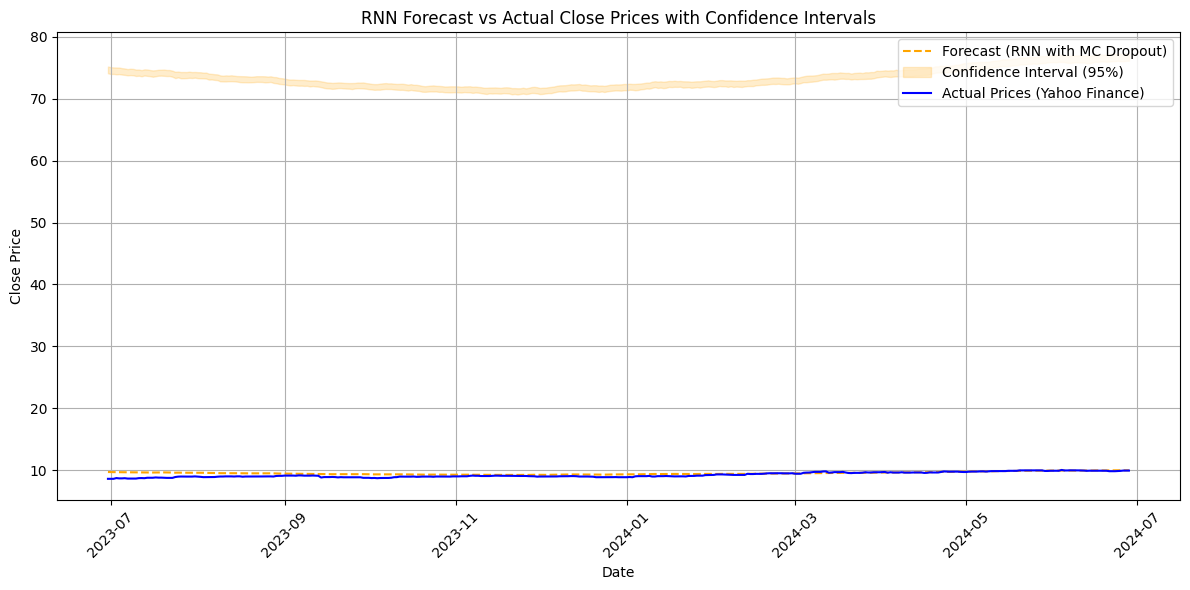

In [40]:
# ---------------------
# Step 3: Forecasting with Confidence Intervals
# ---------------------

import numpy as np

# Load the model and scalers
model = torch.load('forecast/rnn/rnn3_forecast_model.pth').to(device)
model.eval()
feature_scaler = joblib.load("forecast/rnn/feature3_scaler.pkl")
target_scaler = joblib.load("forecast/rnn/target3_scaler.pkl")

# Prepare the input for forecasting
last_sequence = X_test[-seq_len:]  # Last sequence from the test set
last_sequence = torch.tensor(last_sequence, dtype=torch.float32).unsqueeze(0).to(device)

# Perform Monte Carlo dropout inference for confidence intervals
def monte_carlo_dropout_inference(model, inputs, n_simulations=100):
    """
    Perform Monte Carlo dropout during inference to estimate confidence intervals.
    """
    model.train()  # Enable dropout
    predictions = []
    with torch.no_grad():
        for _ in range(n_simulations):
            pred = model(inputs).cpu().numpy()
            predictions.append(pred.flatten())
    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)
    std_prediction = predictions.std(axis=0)
    return mean_prediction, std_prediction

# Generate forecast with Monte Carlo dropout
mean_forecast, std_forecast = monte_carlo_dropout_inference(model, last_sequence, n_simulations=100)

# Denormalize the forecast
mean_forecast = denormalize(mean_forecast, target_scaler)
lower_bound = denormalize(mean_forecast - 1.96 * std_forecast, target_scaler)  # 95% CI
upper_bound = denormalize(mean_forecast + 1.96 * std_forecast, target_scaler)  # 95% CI

# Forecast dates
forecast_dates = pd.date_range(start="2023-06-30", periods=forecast_horizon)

# Fetch actual prices from Yahoo Finance
ticker = "1155.KL"
actual_data = yf.download(ticker, start="2023-06-30", end="2024-07-01")

# Reindex actual data to match forecast dates and forward-fill missing values
actual_data = actual_data.reindex(forecast_dates, method='ffill')  # Forward-fill missing dates
actual_prices = actual_data['Close'].values
actual_dates = actual_data.index

# Debugging outputs
print(f"Forecast Dates: {forecast_dates}")
print(f"Actual Dates: {actual_dates}")
print(f"Forecast Shape: {mean_forecast.shape}, Forecast Values: {mean_forecast}")
print(f"Actual Prices Shape: {actual_prices.shape}, Actual Prices: {actual_prices}")

# ---------------------
# Visualization
# ---------------------

# Plot forecast with confidence intervals and actual prices
plt.figure(figsize=(12, 6))

# Plot mean forecast
plt.plot(forecast_dates, mean_forecast, label="Forecast (RNN with MC Dropout)", linestyle="--", color="orange")

# Plot confidence intervals
plt.fill_between(
    forecast_dates,
    lower_bound,
    upper_bound,
    color="orange",
    alpha=0.2,
    label="Confidence Interval (95%)"
)

# Plot actual prices
plt.plot(actual_dates, actual_prices, label="Actual Prices (Yahoo Finance)", linestyle="-", color="blue")

# Add titles and labels
plt.title("RNN Forecast vs Actual Close Prices with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [39]:
# Ensure alignment between actual and forecast data
if len(actual_prices) != len(forecast):
    print("Warning: Length mismatch between forecast and actual data!")
    # Align by truncating the longer array to match the shorter one
    min_length = min(len(actual_prices), len(forecast))
    actual_prices = actual_prices[:min_length]
    forecast = forecast[:min_length]

# Calculate evaluation metrics
mae = mean_absolute_error(actual_prices, forecast)
mse = mean_squared_error(actual_prices, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - forecast) / actual_prices)) * 100  # In percentage

# Print the metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Evaluation Metrics:
Mean Absolute Error (MAE): 0.3255
Mean Squared Error (MSE): 0.1764
Root Mean Squared Error (RMSE): 0.4200
Mean Absolute Percentage Error (MAPE): 3.62%
